## Whale Optimization Algorithm (WOA)

### Theory

The Whale Optimization Algorithm (WOA), proposed by Mirjalili and Lewis (2016), is a nature-inspired metaheuristic based on the hunting behavior of humpback whales. It mimics a technique called *bubble-net feeding*, in which whales encircle and trap their prey using spiral-shaped motions.

WOA is an iterative algorithm. First, an initial population of whales is generated, and the fitness of each individual is calculated to define the global best solution. At each iteration, whales update their positions based on a random choice among three mechanisms: encircling the prey (local exploitation), spiral attacking (helical movement), or searching for new prey (exploration). The process continues until the maximum number of iterations is reached.

### Movement Strategies

The update of each whale's position is governed by two random vectors:

- $ \vec{A} = 2a \cdot r - a $
- $ \vec{C} = 2r $

Where:
- $a$ decreases linearly from 2 to 0 over the iterations.
- $r$ is a random number in the interval $[0, 1]$.

Based on these vectors and a random probability $p \in [0, 1]$, three strategies are applied:

---

#### 1. Encircling the prey ($p < 0.5$ and $|\vec{A}| < 1$)

The whale moves closer to the best solution found so far ($\vec{X}^*$):

$$
\vec{D} = |\vec{C} \cdot \vec{X}^* - \vec{X}(t)|
$$

$$
\vec{X}(t+1) = \vec{X}^* - \vec{A} \cdot \vec{D}
$$

---

#### 2. Global exploration ($p < 0.5$ and $|\vec{A}| \geq 1$)

The whale moves towards a randomly chosen whale $\vec{X}_{rand}$:

$$
\vec{D} = |\vec{C} \cdot \vec{X}_{rand} - \vec{X}(t)|
$$

$$
\vec{X}(t+1) = \vec{X}_{rand} - \vec{A} \cdot \vec{D}
$$

---

#### 3. Spiral attacking ($p \geq 0.5$)

This simulates the helical motion of whales during the bubble-net feeding process:

$$
\vec{D'} = |\vec{X}^* - \vec{X}(t)|
$$

$$
\vec{X}(t+1) = \vec{D'} \cdot e^{bl} \cdot \cos(2\pi l) + \vec{X}^*
$$

Where:
- $b$ is a constant (typically set to 1),
- $l$ is a random number in the interval $[-1, 1]$.

---

These strategies, applied probabilistically, allow WOA to balance global exploration and local exploitation in an efficient way.


In [5]:
import numpy as np
import pandas as pd
from typing import Tuple
import matplotlib.pyplot as plt
import random

In [6]:
#initialize population:
def initialize_pop_whale(nwhales: int, dim: int, bounds: Tuple[float,float]) -> np.ndarray:
    return np.random.uniform(bounds[0], bounds[1], size=(nwhales, dim))

In [7]:
def update_w_position(whale: np.ndarray, best: np.ndarray, a: float, bounds: Tuple[float,float]) ->np.ndarray:
    #update position of a whale based on WOA rules
    r= np.random.rand()
    A= 2*r-a
    C=2 *np.random.rand()
    p=np.random.rand()
    l=np.random.uniform(-1,1)
    b=1 #constant. to spiral

    if p<0.5:
        if(A)<1:
            D=abs(C*best -whale)
            new_pos =best-A*D
        else:
            rand_whale= np.random.uniform(bounds[0], bounds[1], size=whale.shape)
            D=abs(C*rand_whale - whale)
            new_pos= rand_whale -A*D
    else:
        D=abs(best-whale)
        new_pos=D*np.exp(b*1) *np.cos(2* np.pi *l) + best
    return np.clip(new_pos, bounds[0], bounds[1])


In [8]:
def WOA(fobj, dim: int, bounds: Tuple[float,float], n_whales: int, max_it: int) -> Tuple[np.ndarray, float, list]: 
    population = initialize_pop_whale(n_whales, dim, bounds)
    fitness=[]
    for w in population:
        fitness.append(fobj(w))
    fitness=np.array(fitness)
    best_index= np.argmin(fitness)
    best = population[best_index].copy()
    best_score=fitness[best_index]
    convergence = [best_score]

    for t in range(max_iter):
        a=2-2* (t/max_iter)
        for i in range(n_whales):
            new_pos= update_w_position(population[i], best, a, bounds)
            new_fit=fobj(new_pos)
            if new_fit < fitness[i]:
                population[i]=new_pos
                fitness[i]=new_fit
                if new_fit< best_score:
                    best=new_pos.copy()
                    best_score=new_fit            
        convergence.append(best_score)
    return best, best_score, convergence
    

In [9]:
def ackley(x: np.ndarray, a: float = 20, b: float = 0.2, c: float = 2 * np.pi) -> float:
    d = len(x)
    sum1 = np.sum(x ** 2)
    sum2 = np.sum(np.cos(c * x))

    term1 = -a * np.exp(-b * np.sqrt(sum1 / d))
    term2 = -np.exp(sum2 / d)

    return term1 + term2 + a + np.exp(1)

In [10]:
def rosen(x: np.ndarray) -> float:
    xi = x[:-1]
    xnext= x[1:]
    return np.sum(100*(xnext -xi**2)**2 + (xi-1)**2)
    

melhor posição encontrada: [-1.24530428e-15 -8.62697486e-16  1.59639318e-15 -5.54726850e-16]
melhor valor (fitness): 3.9968028886505635e-15


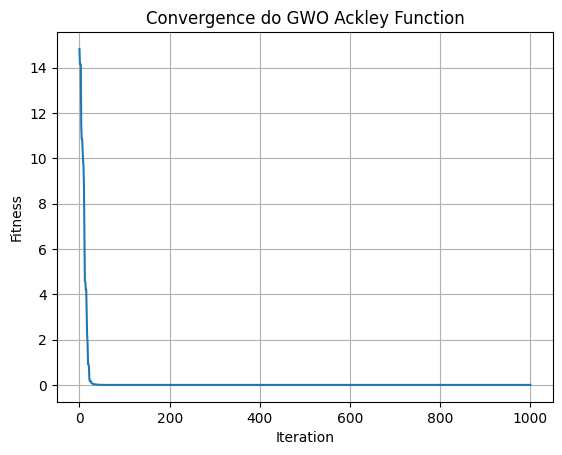

In [12]:
## Ackley test
dim = 4
bounds = (-32.768, 32.768)
n_whales=30
max_iter=1000
best_position, best_value, history = WOA(ackley, dim, bounds, n_whales, max_iter)
# Resultados
print(f"melhor posição encontrada: {best_position}")
print(f"melhor valor (fitness): {best_value}")

# Plot da convergência
plt.plot(history)
plt.title("Convergence do GWO Ackley Function")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.grid()
plt.show()


melhor posição encontrada: [1. 1. 1.]
melhor valor (fitness): 0.0


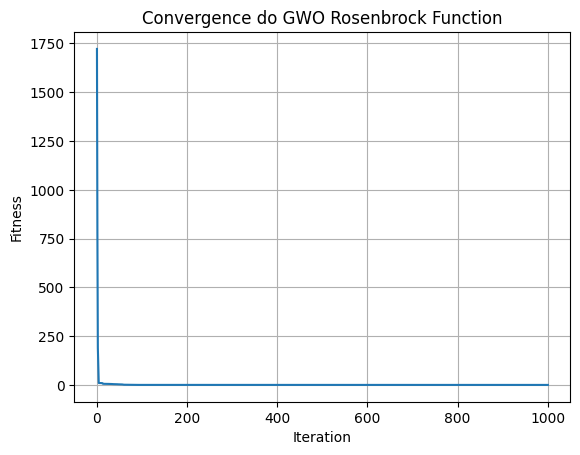

In [13]:
# rosen Test
dim = 3
bounds = (-5, 10)
n_whales=30
max_iter=1000
best_position, best_value, history = WOA(rosen, dim, bounds, n_whales, max_iter)
# Resultados
print(f"melhor posição encontrada: {best_position}")
print(f"melhor valor (fitness): {best_value}")

# Plot da convergência
plt.plot(history)
plt.title("Convergence do GWO Rosenbrock Function")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.grid()
plt.show()


melhor posição encontrada: [0.93837438 0.88317136 0.78900701 0.61827929 0.35869641]
melhor valor (fitness): 0.27386864890487406


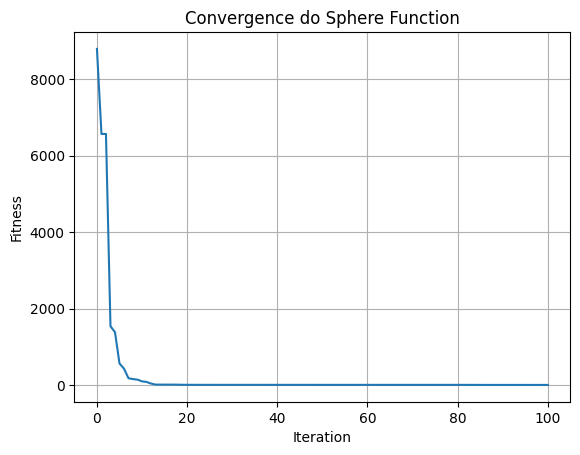

In [14]:
# Sphere Test
dim = 5
bounds = (-5.12, 5.12)
n_wolves=5
max_iter=100
best_position, best_value, history = WOA(rosen, dim, bounds, n_whales, max_iter)
# Resultados
print(f"melhor posição encontrada: {best_position}")
print(f"melhor valor (fitness): {best_value}")

# Plot da convergência
plt.plot(history)
plt.title("Convergence do Sphere Function")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.grid()
plt.show()



### Reference

Mirjalili, S., & Lewis, A. (2016). *The Whale Optimization Algorithm*. Advances in Engineering Software, 95, 51–67. https://doi.org/10.1016/j.advengsoft.2016.01.008
